In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os, json, h5py
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory  = "./images_jpg", 
    color_mode = 'rgb',     
    batch_size = 32,
    image_size = (256, 256),  
    shuffle    = True,
    seed       = None,
    crop_to_aspect_ratio = False,
)

Found 1125 files belonging to 15 classes.


In [3]:
class_names = dataset.class_names
print(class_names)
sample_batch = dataset.take(1)
for image_batch, label_batch in sample_batch:
    print(image_batch.shape)
    print(label_batch.numpy())

['Brzoza', 'Buk', 'Dab', 'Jarzab', 'Jarzab_pospolity', 'Klon', 'Lipa', 'Olcha_szara', 'Topola', 'Topola_osika', 'Wiaz', 'Wiaz_gorski', 'Wierzba', 'Wierzba_biala', 'Wierzba_siwa']
(32, 256, 256, 3)
[ 0 14 11 10  8 13 11  0  6 12  8  0  0  7  1  2 11 12  1  7  8 13  4  8
  3  8 11  9  0 13  0  6]


In [4]:
def split_dataset(ds, ratios=(8, 1, 1,)):
    total = sum(ratios)
    ds_size = len(ds)
    skip = 0
    for ratio in ratios[:-1]:
        size = int(ds_size * ratio/total)
        yield ds.skip(skip).take(size)
        skip += size
    yield ds.skip(skip)

train_dataset, val_dataset, test_dataset = split_dataset(dataset, (240, 16, 1))

# ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Total:", len(dataset))
print("Train:", len(train_dataset))
print("Valid:", len(val_dataset))
print("Test :", len(test_dataset))

Total: 36
Train: 33
Valid: 2
Test : 1


In [5]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Zablokowanie warstw wstępnie wytrenowanego modelu
for layer in base_model.layers:
    layer.trainable = False

# Dodanie nowych warstw
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])

16705208/16705208 [==============================] - 1s 0us/step


In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # No need for from_logits=True
              metrics=['accuracy'])

In [7]:
keras_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    #   callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
]

In [8]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
33/33 [==============================] - 61s 2s/step - loss: 0.5974 - accuracy: 0.8324 - val_loss: 0.0491 - val_accuracy: 1.0000
Epoch 2/10
33/33 [==============================] - 49s 1s/step - loss: 0.0599 - accuracy: 0.9830 - val_loss: 0.0554 - val_accuracy: 0.9844
Epoch 3/10
33/33 [==============================] - 49s 1s/step - loss: 0.0503 - accuracy: 0.9858 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 4/10
33/33 [==============================] - 49s 1s/step - loss: 0.0348 - accuracy: 0.9896 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/10
33/33 [==============================] - 49s 1s/step - loss: 0.0369 - accuracy: 0.9905 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 49s 1s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 49s 1s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/10
33/33 [==

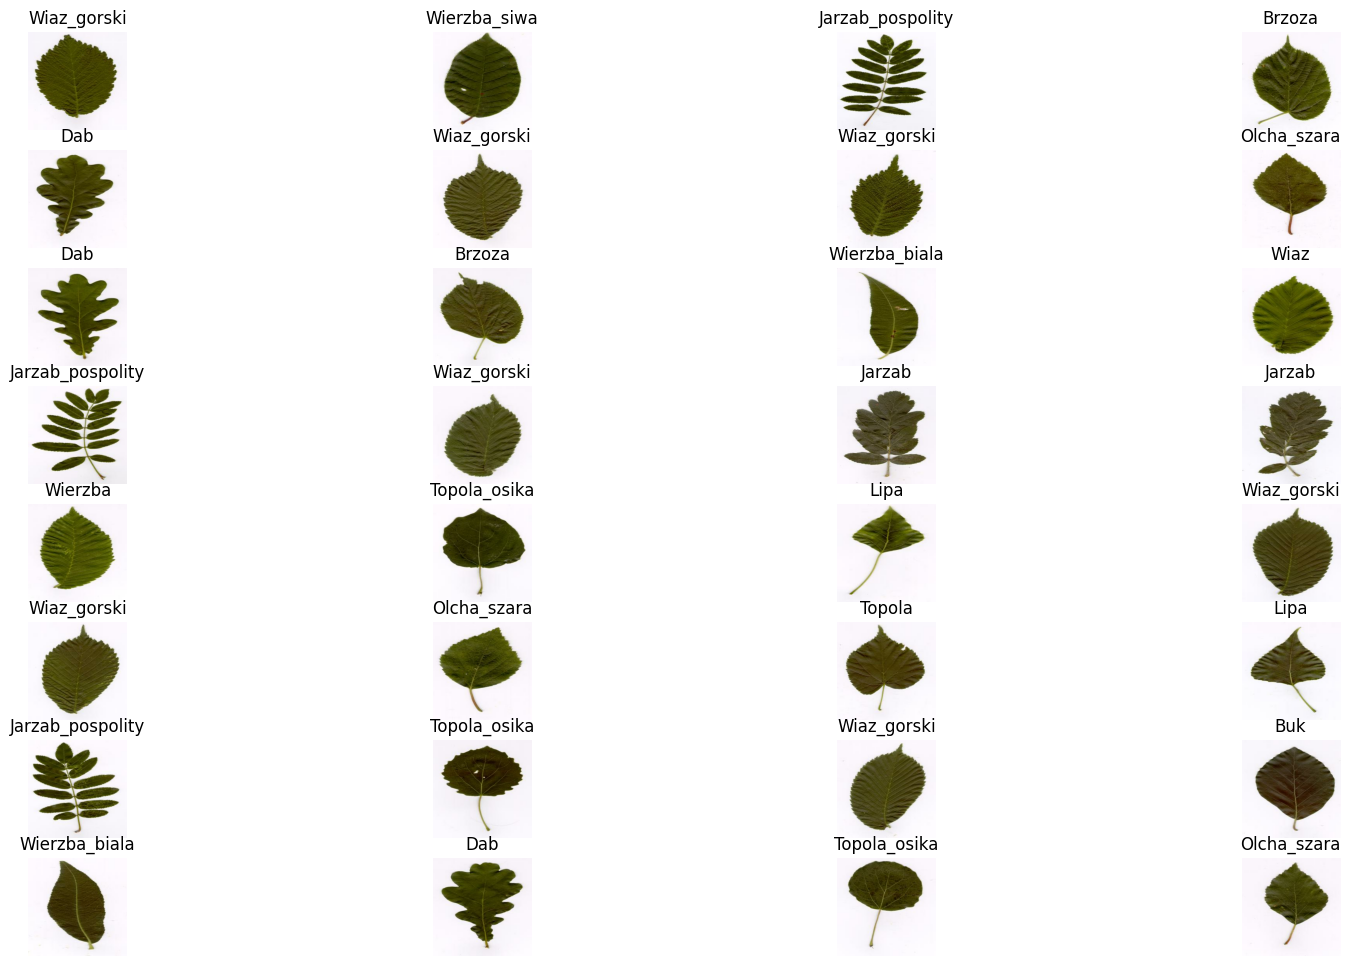

In [9]:
plt.figure(figsize=(20, 12))
for image_batch, label_batch in sample_batch:
    size = len(image_batch)
    columns = 4
    rows = size//columns
    for i in range(size):
        ax = plt.subplot(rows, columns, i + 1)   # rows, cols, idx
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # converting float to int
        plt.axis("off")

1/1 [==============================] - 0s 269ms/step


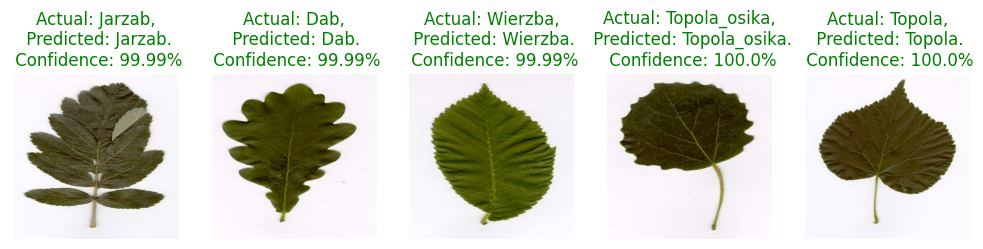

In [40]:
plt.figure(figsize=(20, 20))

# take a batch from 'test_ds'
for image_batch, label_batch in test_dataset.take(1):
    
    # returns array of confidences for different classes of all images in the batch
    prediction_batch = model.predict(image_batch)

    size = len(image_batch)
    columns = 8
    rows = (size + columns - 1) // columns  # Calculate the number of rows needed dynamically
    
    for i in range(size):
        
        image = image_batch[i].numpy().astype("uint8")   # converting float to int
        
        actual_class    = class_names[label_batch[i]]
        predicted_class = class_names[np.argmax(prediction_batch[i])]
        confidence      = round(100 * (np.max(prediction_batch[i])), 2)
        
        # Calculate the subplot index dynamically
        ax = plt.subplot(rows, columns, i + 1)   # row, col, idx

        title = plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.setp(title, color='g' if actual_class == predicted_class else 'r')
        plt.imshow(image)
        plt.axis("off")


In [11]:
model.save('leaf_classifier.h5')

c:\Users\Micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model_path = "leaf_classifier.h5"
model = tf.keras.models.load_model(model_path)

In [13]:
if hasattr(model, 'class_names'):
    class_names = model.class_names
class_names


# Load the image
image_path = "test_images\Lisc_lipy.jpg"
image = tf.keras.utils.load_img(image_path)


In [14]:
if hasattr(model, 'class_names'):
    class_names = model.class_names
class_names

['Brzoza',
 'Buk',
 'Dab',
 'Jarzab',
 'Jarzab_pospolity',
 'Klon',
 'Lipa',
 'Olcha_szara',
 'Topola',
 'Topola_osika',
 'Wiaz',
 'Wiaz_gorski',
 'Wierzba',
 'Wierzba_biala',
 'Wierzba_siwa']

In [33]:
image_path = "test_images\jarzabszwedzki.jpeg"
image = tf.keras.utils.load_img(image_path)

In [34]:
target_size = (256, 256)
image = tf.image.resize(np.array(image), target_size)

In [35]:
input_arr = tf.keras.utils.img_to_array(image) / 255.0
input_arr = np.array([input_arr])  # Convert single image to a batch.

In [36]:
predictions = model.predict(input_arr) 
predicted_class = class_names[np.argmax(predictions)]
confidence = round(100 * (np.max(tf.nn.softmax(predictions))), 2)

1/1 [==============================] - 0s 93ms/step


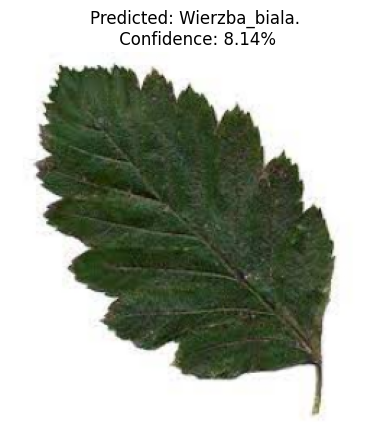

In [37]:
plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.imshow(input_arr[0])  # Display the normalized image
plt.axis("off")
plt.show()


In [20]:
model.summary()

# Get the list of layers in the model
layers_list = model.layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 15)                15375     
                                                                 
Total params: 5376690 (20.51 MB)
Trainable params: 13271

In [21]:
for layer in layers_list:
    print(f"Layer: {layer.name}")
    weights = layer.get_weights()
    if weights:
        print(f"Number of weights: {len(weights)}")
        for i, weight_array in enumerate(weights):
            print(f"  Weight {i + 1} shape: {weight_array.shape}")
    else:
        print("No weights in this layer")
    print("\n")

    plt.figure(figsize=(20, 20))

Layer: efficientnetb0
Number of weights: 312
  Weight 1 shape: (3,)
  Weight 2 shape: (3,)
  Weight 3 shape: ()
  Weight 4 shape: (3, 3, 3, 32)
  Weight 5 shape: (32,)
  Weight 6 shape: (32,)
  Weight 7 shape: (32,)
  Weight 8 shape: (32,)
  Weight 9 shape: (3, 3, 32, 1)
  Weight 10 shape: (32,)
  Weight 11 shape: (32,)
  Weight 12 shape: (32,)
  Weight 13 shape: (32,)
  Weight 14 shape: (1, 1, 32, 8)
  Weight 15 shape: (8,)
  Weight 16 shape: (1, 1, 8, 32)
  Weight 17 shape: (32,)
  Weight 18 shape: (1, 1, 32, 16)
  Weight 19 shape: (16,)
  Weight 20 shape: (16,)
  Weight 21 shape: (16,)
  Weight 22 shape: (16,)
  Weight 23 shape: (1, 1, 16, 96)
  Weight 24 shape: (96,)
  Weight 25 shape: (96,)
  Weight 26 shape: (96,)
  Weight 27 shape: (96,)
  Weight 28 shape: (3, 3, 96, 1)
  Weight 29 shape: (96,)
  Weight 30 shape: (96,)
  Weight 31 shape: (96,)
  Weight 32 shape: (96,)
  Weight 33 shape: (1, 1, 96, 4)
  Weight 34 shape: (4,)
  Weight 35 shape: (1, 1, 4, 96)
  Weight 36 shape: (96

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>